In [2]:
#set path to folder above this
import sys
sys.path.append("..")
import numpy as np
from torch.distributions.categorical import Categorical
from utils import live_plot
from environments.ALFWorldEnvironment import ALFWorldEnvironment
from sentence_transformers import SentenceTransformer

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import tqdm
import gym
import pickle

In [3]:
# #auto reload
%load_ext autoreload
%autoreload 2
#enable live plot
%matplotlib inline

### Generate pre-training data using expert agent

In [4]:
env = ALFWorldEnvironment()

Initializing AlfredTWEnv...


100%|██████████| 8810/8810 [00:04<00:00, 1936.65it/s]

Overall we have 790 games in split=train
Training with 790 games


generate trajectories

In [6]:
# generate expert trajectories
trajectories = []

state, _ = env.reset()

TOTAL_NUM_GAMES = 790
num_episodes = 0

with tqdm.tqdm(total=TOTAL_NUM_GAMES) as pbar:
    while num_episodes < TOTAL_NUM_GAMES:
        state_text = env.state_to_text(state)
        action = state['expert_actions'][0]
        next_state, reward, done, _, _ = env.step(action)
        next_state_text = env.state_to_text(next_state)
        
        trajectories.append((num_episodes, state_text, action, reward, next_state_text, done))
        
        if done:
            state, _ = env.reset()
            num_episodes += 1
            pbar.update(1)
        else:
            state = next_state
        
# save trajectories
import pickle

with open("trajectories/alfworld_expert_trajectories.pkl", "wb") as f:
    pickle.dump(trajectories, f)    

100%|██████████| 790/790 [31:54<00:00,  2.42s/it]


## NLP Policy Network

### Define Policy Network

1. `all-mpnet-base-v2` as backbone to transform text state into latent state
2. self-attention transformer layers to relevant attention information (since the embedding is not being trained)
3. FFC to get q-values vector.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModel
from typing import List
from sentence_transformers import util as st_utils

class CosineSimilarityLayer(nn.Module):
    def __init__(self, embedding_dim, device='cuda'):
        self.cos_sim_model = SentenceTransformer('paraphrase-MiniLM-L6-v2').to(self.device)

    def forward(self, out_embedding, valid_actions_text):
        out_embedding = self.cos_sim_model.encode(out_embedding, convert_to_tensor=True)
        action_embeddings = self.cos_sim_model.encode(valid_actions_text, convert_to_tensor=True)
        cos_sim = st_utils.pytorch_cos_sim(out_embedding, action_embeddings)
        cos_sim = cos_sim.cpu().numpy()
        
        COS_SIM_THRESHOLD = 0.7
    
        similar_actions = []
        
        for i, cs in enumerate(cos_sim):
            if np.max(cs) > COS_SIM_THRESHOLD:
                similar_actions.append(valid_actions_text[np.argmax(cs)])
            else:
                if self.debug:
                    print(f"Warning: No similar action found for action")
                similar_actions.append(None)    # do not consider this action


class TransformerNetwork(nn.Module):
    def __init__(self, 
                 embedding_dim=768,
                 output_dim=4,
                 num_transformer_layers=1,
                 ):
        super(TransformerNetwork, self).__init__()
                
        self.embedding_dim = embedding_dim

        decoder_layer = nn.TransformerDecoderLayer(d_model=self.embedding_dim, nhead=8, dim_feedforward=2048)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_transformer_layers)

        self.cos_sim_layer = CosineSimilarityLayer(embedding_dim)
    
    def forward(self, embeddings):
        assert isinstance(embeddings, torch.Tensor), f"Expected input type torch.Tensor but got {type(embeddings)}"
        assert embeddings.shape[-1] == self.embedding_dim, f"Expected input shape [batch_size, seq_len, {self.embedding_dim}] but got {embeddings.shape}"
        
        transformer_output = self.transformer_encoder(embeddings)  # Shape: [batch_size, seq_len, embedding_dim]
        
        # Average the transformer output across the sequence dimension
        pooled_output = transformer_output.mean(dim=1)
        
        # Output Q-values
        q_values = self.fc(pooled_output)  # Shape: [batch_size, num_actions]
        return q_values
        
class NLPolicyNetwork(nn.Module):
    def __init__(self, 
                 encoder_name='sentence-transformers/all-mpnet-base-v2',
                 action_space_n=4,
                 num_transformer_layers=1,
                 fc_hidden_dims=[512, 256],
                 device='cuda'
                 ):
        super(NLPolicyNetwork, self).__init__()
                
        self.tokenizer = AutoTokenizer.from_pretrained(encoder_name)
        self.encode_model = AutoModel.from_pretrained(encoder_name).to(device).eval()
        self.device = device   
        self.embedding_dim = self.encode_model.config.hidden_size
        
        # self.DQN = TransformerNetwork(
        #     embedding_dim=self.embedding_dim,
        #     output_dim=action_space_n,
        #     num_transformer_layers=num_transformer_layers,
        #     fc_hidden_dims=fc_hidden_dims
        # ).to(device)
        
    def forward(self, states: List[str]):
        # print(type(states))
        print(states)
        states = self.tokenizer(states, padding=True, truncation=True, return_tensors="pt") # Shape: [batch_size, seq_len, embedding_dim]
        print(states)
        states = {k: v.to(self.device) for k, v in states.items()}
        print(states)
        return
        
        # Pass state through the encoder
        with torch.no_grad():
            state_embeddings = self.encode_model(**states).last_hidden_state  # Shape: [batch_size, seq_len, embedding_dim]
        
        # Pass embeddings through the DQN
        q_values = self.DQN(state_embeddings)
        
        return q_values
    

/home/carlenovo/CS5242Proj/LLMZero/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
test = ['Test token']
model = NLPolicyNetwork()
out = model(test)

['Test token']
{'input_ids': tensor([[    0,  3235, 19208,     2]]), 'attention_mask': tensor([[1, 1, 1, 1]])}


AttributeError: 'NLPolicyNetwork' object has no attribute 'DQN'

: 

## NLP Actor Critic Network with PPO

PPO is supposed to have more stable training compared to DQN, let's test it out.

### Define ActorCritic Network

In [6]:
from typing import List
from torch.distributions.categorical import Categorical

class NLActorCriticNetwork(nn.Module):
    def __init__(self, 
                 encoder_name='sentence-transformers/all-mpnet-base-v2',
                 action_space_n=4,
                 num_transformer_layers_shared=0,
                 num_transformer_layers_actor=1,
                 num_transformer_layers_critic=1,
                 fc_hidden_dims=[512, 256],
                 device='cuda'
                 ):
        super(NLActorCriticNetwork, self).__init__()
                
        self.tokenizer = AutoTokenizer.from_pretrained(encoder_name)
        self.encode_model = AutoModel.from_pretrained(encoder_name).to(device).eval()
        self.device = device   
        self.embedding_dim = self.encode_model.config.hidden_size
        
        transformer = nn.TransformerEncoderLayer(
            d_model=self.embedding_dim, nhead=8, dim_feedforward=2048
        )
        
        self.shared_encoder = \
            nn.TransformerEncoder(transformer, num_layers=num_transformer_layers_shared).to(device) \
            if num_transformer_layers_shared > 0 else nn.Identity()
        
        self.actor = TransformerNetwork(
            embedding_dim=self.embedding_dim,
            output_dim=action_space_n,
            num_transformer_layers=num_transformer_layers_actor,
            fc_hidden_dims=fc_hidden_dims
        ).to(device)
        
        self.critic = TransformerNetwork(           
            embedding_dim=self.embedding_dim,
            output_dim=1,
            num_transformer_layers=num_transformer_layers_critic,
            fc_hidden_dims=fc_hidden_dims,
            fc_output_std=1.0
        ).to(device)
            
    def get_value(self, states: List[str]):
        """Calculate the estimated value for a given state.

        Args:
            states (List[str]): List of states as strings, shape: [batch_size]

        Returns:
            torch.Tensor: Estimated value for the state, shape: (batch_size, 1)
        """
        shared_embeddings = self.get_shared_embeddings(states)
        
        return self._get_value(shared_embeddings)
    
    def _get_value(self, shared_embeddings: torch.Tensor):
        """ get value from shared embeddings """
        return self.critic(shared_embeddings)
    
    def get_probs(self, states: List[str]):
        """Calculate the action probabilities for a given state.

        Args:
            states (List[str]): List of states as strings, shape: [batch_size]

        Returns:
            torch.distributions.Categorical: Categorical distribution over actions
        """
        shared_embeddings = self.get_shared_embeddings(states)
        
        return self._get_probs(shared_embeddings)
    
    def _get_probs(self, shared_embeddings: torch.Tensor):
        """ get action probabilities from shared embeddings """
        return Categorical(logits=self.actor(shared_embeddings))
        
    def tokenize_states(self, states: List[str]):
        """ Tokenize list of states (str) and return as dictionary of tensors 
        Args:
            states (List[str]): List of states as strings, shape: [batch_size]
            
        Returns:
            states_tokenized (Dict[str, torch.Tensor]): Dictionary of tokenized states as tensors
        """
                
        states_tokenized = self.tokenizer(list(states), padding=True, truncation=True, return_tensors="pt")
        states_tokenized = {k: v.to(self.device) for k, v in states_tokenized.items()}
        
        return states_tokenized
    
    def get_shared_embeddings(self, states: List[str]):
        """ get shared embeddings """
        states_tokenized = self.tokenize_states(states)
        
        with torch.no_grad():
            state_embeddings = self.encode_model(**states_tokenized).last_hidden_state
            
        shared_embeddings = self.shared_encoder(state_embeddings)
        
        return shared_embeddings
    
    def get_action(self, probs: Categorical):
        """Sample an action from the action distribution.

        Args:
            probs (torch.distributions.Categorical): Action probabilities.

        Returns:
            torch.Tensor: Sampled action, shape: (batch_size, 1)
        """
        sample = probs.sample()    # shape: [batch_size]
        return sample
    
    def get_action_logprob(self, probs: Categorical, actions: torch.Tensor):
        """Compute the log probability of a given action.

        Args:
            probs (torch.distributions.Categorical): Action probabilities.
            actions (torch.Tensor): Selected action, shape: (batch_size, 1)

        Returns:
            torch.Tensor: Log probability of the action, shape: (batch_size, 1)
        """
        return probs.log_prob(actions)
    
    def get_entropy(self, probs: Categorical):
        """Calculate the entropy of the action distribution.

        Args:
            probs (torch.distributions.Categorical): Action probabilities.

        Returns:
            torch.Tensor: Entropy of the distribution, shape: (batch_size, 1)
        """
        return probs.entropy()
    
    def get_action_logprob_entropy(self, states: List[str]):
        """Get action, log probability, and entropy for a given state.

        Args:
            states (List[str]): List of states as strings, shape: [batch_size]

        Returns:
            tuple: (action, logprob, entropy)
                - action (torch.Tensor): Sampled action.
                - logprob (torch.Tensor): Log probability of the action.
                - entropy (torch.Tensor): Entropy of the action distribution.
        """
        
        probs = self.get_probs(states)  # Get action probabilities
        action = self.get_action(probs)  # Sample an action
        logprob = self.get_action_logprob(probs, action)  # Compute log probability of the action
        entropy = self.get_entropy(probs)  # Compute entropy of the action distribution
        return action, logprob, entropy  # Return action, log probability, and entropy
        
        

In [7]:
agent = NLActorCriticNetwork(device='cuda')

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [8]:
test_action = agent.get_action_logprob_entropy(["open door", "close door"] * 4)
print(test_action[0].shape, test_action[1].shape, test_action[2].shape)

torch.Size([8]) torch.Size([8]) torch.Size([8])


### Hyperparameters


In [ ]:
LEARNING_RATE = 1e-4 #2.5e-4
NUM_ENVS = 8

ROLLOUT_STEPS = 128
NUM_MINI_BATCHES = NUM_EPOCHS = 8 #4
TOTAL_STEPS = 2000000 + 500 * ROLLOUT_STEPS * NUM_ENVS

GAMMA = 0.99
GAE_LAMBDA = 0.95

CLIP_COEF = 0.05 # 0.1 (iter 1552) # 0.2 before iter 682
VALUE_LOSS_COEF = 0.5
ENTROPY_COEF = 0.005 # 0.005 # 0.01 before iter 682 # was 0.05 before iter 561

min_reward, max_reward = -52.5, 300 # compute from expert

device = 'cuda'

BATCH_SIZE = ROLLOUT_STEPS * NUM_ENVS
MINI_BATCH_SIZE = BATCH_SIZE // NUM_MINI_BATCHES
NUM_ITERATIONS = TOTAL_STEPS // BATCH_SIZE
SAVE_INTERVAL = NUM_ITERATIONS // 10            # save long term
CHECKPOINT_INTERVAL = NUM_ITERATIONS // 50     # save as latest checkpoint

### Prepare vectorized environment

In [10]:
import gym.wrappers

def create_elevator_env():
    env = ElevatorEnvironment()
    env = gym.wrappers.RecordEpisodeStatistics(env)
    
    return env

env_vectorized = gym.vector.SyncVectorEnv([lambda: create_elevator_env() for _ in range(NUM_ENVS)])

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with

c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Core\Env\RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples c:\Users\ianch\miniconda3\envs\aiplanning\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with

### Define the rollout buffer

In [17]:
from collections import deque

state_buffer = deque(maxlen=ROLLOUT_STEPS*NUM_ENVS)
action_buffer = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
reward_buffer = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
done_buffer = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)

logprob_buffer = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
value_buffer = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)

### Compute Advantages and Losses

In [12]:
def get_deltas(rewards, values, next_values, next_nonterminal, gamma):
    """Compute the temporal difference (TD) error.

    Args:
        rewards (torch.Tensor): Rewards at each time step, shape: (batch_size,).
        values (torch.Tensor): Predicted values for each state, shape: (batch_size,).
        next_values (torch.Tensor): Predicted value for the next state, shape: (batch_size,).
        gamma (float): Discount factor.

    Returns:
        torch.Tensor: Computed TD errors, shape: (batch_size,).
    """
    deltas = rewards + gamma * next_values * next_nonterminal - values  

    return deltas

def get_ratio(logprob, logprob_old):
    """Compute the probability ratio between the new and old policies.

    This function calculates the ratio of the probabilities of actions under
    the current policy compared to the old policy, using their logarithmic values.

    Args:
        logprob (torch.Tensor): Log probability of the action under the current policy,
                                shape: (batch_size,).
        logprob_old (torch.Tensor): Log probability of the action under the old policy,
                                    shape: (batch_size,).

    Returns:
        torch.Tensor: The probability ratio of the new policy to the old policy,
                      shape: (batch_size,).
    """
    logratio = logprob - logprob_old 
    ratio = torch.exp(logratio) # Exponentiate to get the probability ratio

    return ratio

def get_policy_objective(advantages, ratio, clip_coeff=CLIP_COEF):
    """Compute the clipped surrogate policy objective.

    This function calculates the policy objective using the advantages and the
    probability ratio, applying clipping to stabilize training.

    Args:
        advantages (torch.Tensor): The advantage estimates, shape: (batch_size,).
        ratio (torch.Tensor): The probability ratio of the new policy to the old policy,
                             shape: (batch_size,).
        clip_coeff (float, optional): The clipping coefficient for the policy objective.
                                       Defaults to CLIP_COEF.

    Returns:
        torch.Tensor: The computed policy objective, a scalar value.
    """
    policy_objective1 = ratio * advantages # Calculate the first policy loss term
    policy_objective2 = torch.clamp(ratio, 1 - clip_coeff, 1 + clip_coeff) * advantages # Calculate the clipped policy loss term
    policy_objective = torch.mean(torch.min(policy_objective1, policy_objective2)) # Take the minimum and average over the batch
    
    return policy_objective

def get_value_loss(values, values_old, returns):
    """Compute the combined value loss with clipping.

    This function calculates the unclipped and clipped value losses
    and returns the maximum of the two to stabilize training.

    Args:
        values (torch.Tensor): Predicted values from the critic, shape: (batch_size, 1).
        values_old (torch.Tensor): Old predicted values from the critic, shape: (batch_size, 1).
        returns (torch.Tensor): Computed returns for the corresponding states, shape: (batch_size, 1).

    Returns:
        torch.Tensor: The combined value loss, a scalar value.
    """
    value_loss_unclipped = 0.5 * (values - returns) ** 2 # Calculate unclipped value loss
    value_loss_clipped = 0.5 * (torch.clamp(values - values_old, -CLIP_COEF, CLIP_COEF) + values_old - returns) ** 2
    value_loss = torch.mean(torch.max(value_loss_unclipped, value_loss_clipped)) # Average over the batch

    return value_loss  # Return the final combined value loss

def get_entropy_objective(entropy):
    """Compute the entropy objective.

    This function calculates the average entropy of the action distribution,
    which encourages exploration by penalizing certainty.

    Args:
        entropy (torch.Tensor): Entropy values for the action distribution, shape: (batch_size,).

    Returns:
        torch.Tensor: The computed entropy objective, a scalar value.
    """
    return entropy.mean()  # Return the average entropy

def get_total_loss(policy_objective, value_loss, entropy_objective, value_loss_coeff=VALUE_LOSS_COEF, entropy_coeff=ENTROPY_COEF):
    """Compute the total loss for the actor-critic agent.

    This function combines the policy objective, value loss, and entropy objective
    into a single loss value for optimization. It applies coefficients to scale
    the contribution of the value loss and entropy objective.

    Args:
        policy_objective (torch.Tensor): The policy objective, a scalar value.
        value_loss (torch.Tensor): The computed value loss, a scalar value.
        entropy_objective (torch.Tensor): The computed entropy objective, a scalar value.
        value_loss_coeff (float, optional): Coefficient for scaling the value loss. Defaults to VALUE_LOSS_COEF.
        entropy_coeff (float, optional): Coefficient for scaling the entropy loss. Defaults to ENTROPY_COEF.

    Returns:
        torch.Tensor: The total computed loss, a scalar value.
    """
    total_loss = - policy_objective + value_loss_coeff * value_loss - entropy_coeff * entropy_objective # Combine losses

    return total_loss

### PPO Training Loop

In [13]:
def get_text_states(states):
    states_text = ElevatorEnvironment.state_to_text_vectorized(states)
    return [s for s in states_text]

In [18]:
# keep track of progress to enable resuming training
latest_save_iteration = 1
latest_save_model = "weights/elevator_actor_critic_latest.pt"

actor_loss_history = []
critic_loss_history = []
entropy_objective_history = []

reward_history = []
episode_history = []

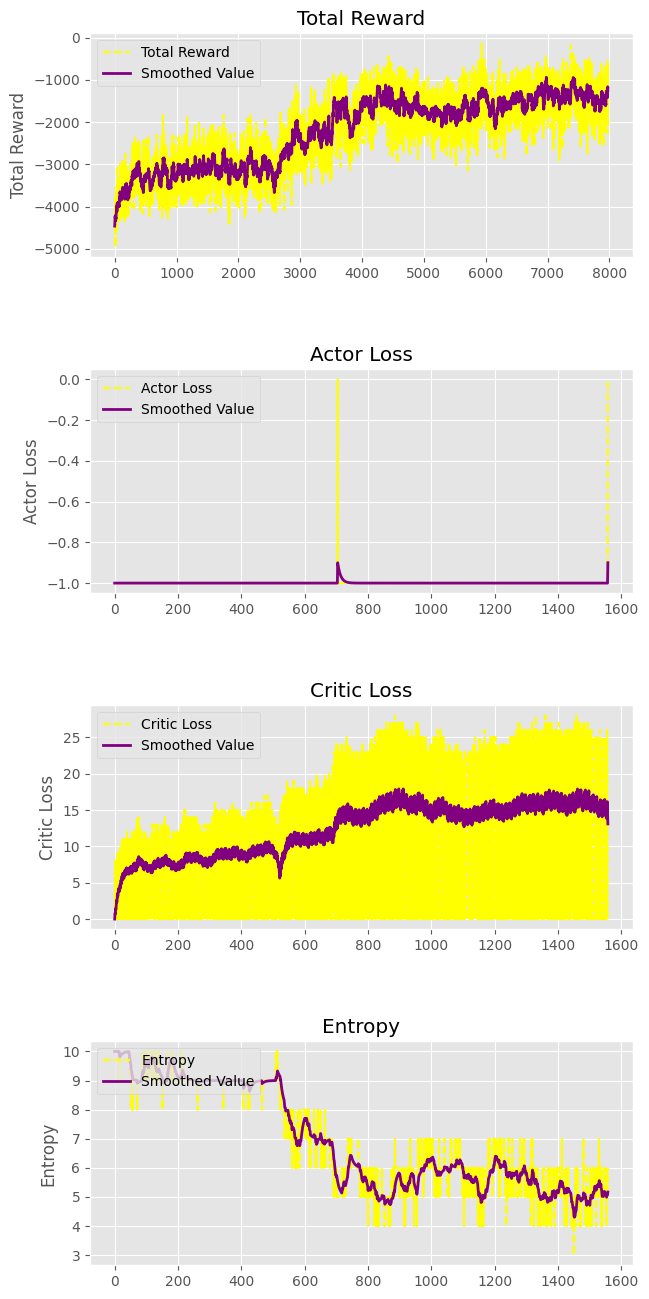

 63%|██████▎   | 1552/2453 [00:39<00:22, 39.47it/s, Total Rewards=0]


KeyboardInterrupt: 

In [109]:
# Enable inline plotting
%matplotlib inline

# Initialize global step counter and reset the environment
global_step = 0
initial_state, _ = env_vectorized.reset()
state = get_text_states(initial_state)
done = torch.zeros(NUM_ENVS).to(device)

# Set up progress tracking
progress_bar = tqdm.tqdm(range(1, NUM_ITERATIONS + 1), postfix={'Total Rewards': 0})

# Initialize the optimizer for the agent's parameters
optimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE, eps=1e-5)

agent.train()  # Set the agent in training mode

for iteration in progress_bar:
    if iteration < latest_save_iteration:
        continue
    
    # Adjust the learning rate using a linear decay
    fraction_completed = 1.0 - (iteration - 1.0) / NUM_ITERATIONS
    current_learning_rate = fraction_completed * LEARNING_RATE
    optimizer.param_groups[0]["lr"] = current_learning_rate

    # Perform rollout to gather experience
    for step in range(0, ROLLOUT_STEPS):
        global_step += NUM_ENVS
        state_buffer.extend(state)
        done_buffer[step] = done

        with torch.no_grad():
            # Get action, log probability, and entropy from the agent
            action, log_probability, _ = agent.get_action_logprob_entropy(state)
            value = agent.get_value(state)
            value_buffer[step] = value.flatten()

        action_buffer[step] = action
        logprob_buffer[step] = log_probability

        # Execute action in the environment
        next_state, reward, done, _, info = env_vectorized.step(action.cpu().numpy())
        next_state = get_text_states(next_state)
        normalized_reward = (reward - min_reward) / (max_reward - min_reward)  # Normalize the reward
        reward_buffer[step] = torch.tensor(normalized_reward).to(device).view(-1)
        state = next_state
        done = torch.Tensor(done).to(device)

        if "final_info" in info:
            for episode_info in info["final_info"]:
                if episode_info and "episode" in episode_info:
                    episodic_reward = episode_info['episode']['r']
                    reward_history.append(episodic_reward)
                    episode_history.append(global_step)
                    progress_bar.set_postfix({'Total Rewards': episodic_reward})

    # Calculate advantages and returns
    with torch.no_grad():
        next_value = agent.get_value(state).reshape(1, -1)
        advantage_buffer = torch.zeros_like(reward_buffer).to(device)

        last_gae_lambda = 0
        for t in reversed(range(ROLLOUT_STEPS)):
            if t == ROLLOUT_STEPS - 1:
                next_non_terminal = 1.0 - done
                next_value = next_value
            else:
                next_non_terminal = 1.0 - done_buffer[t + 1]
                next_value = value_buffer[t + 1]

            # Compute delta using the utility function
            delta = get_deltas(reward_buffer[t], value_buffer[t], next_value, next_non_terminal, gamma=GAMMA)

            advantage_buffer[t] = last_gae_lambda = delta + GAMMA * GAE_LAMBDA * next_non_terminal * last_gae_lambda
        return_buffer = advantage_buffer + value_buffer

    # Flatten the batch data for processing
    batch_states = np.array(state_buffer, dtype=object)
    batch_logprobs = logprob_buffer.reshape(-1)
    batch_actions = action_buffer.reshape((-1))
    batch_advantages = advantage_buffer.reshape(-1)
    batch_returns = return_buffer.reshape(-1)
    batch_values = value_buffer.reshape(-1)

    # Shuffle the batch data to break correlation between samples
    batch_indices = np.arange(BATCH_SIZE)
    total_actor_loss = 0
    total_critic_loss = 0
    total_entropy_objective = 0

    for epoch in range(NUM_EPOCHS):
        np.random.shuffle(batch_indices)
        for start in range(0, BATCH_SIZE, MINI_BATCH_SIZE):
            # Get the indices for the mini-batch
            end = start + MINI_BATCH_SIZE
            mini_batch_indices = batch_indices[start:end]

            mini_batch_advantages = batch_advantages[mini_batch_indices]
            # Normalize advantages to stabilize training
            mini_batch_advantages = (mini_batch_advantages - mini_batch_advantages.mean()) / (mini_batch_advantages.std() + 1e-8)

            # Compute new probabilities and values for the mini-batch
            new_probabilities = agent.get_probs(batch_states[mini_batch_indices])
            new_log_probability = agent.get_action_logprob(new_probabilities, batch_actions.long()[mini_batch_indices])
            entropy = agent.get_entropy(new_probabilities)
            new_value = agent.get_value(batch_states[mini_batch_indices])

            # Calculate the policy loss
            ratio = get_ratio(new_log_probability, batch_logprobs[mini_batch_indices])
            policy_objective = get_policy_objective(mini_batch_advantages, ratio, clip_coeff=CLIP_COEF)
            policy_loss = -policy_objective

            # Calculate the value loss
            value_loss = get_value_loss(new_value.view(-1), batch_values[mini_batch_indices], batch_returns[mini_batch_indices])

            # Calculate the entropy loss
            entropy_objective = get_entropy_objective(entropy)

            # Combine losses to get the total loss
            total_loss = get_total_loss(policy_objective, value_loss, entropy_objective, value_loss_coeff=VALUE_LOSS_COEF, entropy_coeff=ENTROPY_COEF)

            optimizer.zero_grad()
            total_loss.backward()
            # Clip the gradient to stabilize training
            nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
            optimizer.step()

            total_actor_loss += policy_loss.item()
            total_critic_loss += value_loss.item()
            total_entropy_objective += entropy_objective.item()

    actor_loss_history.append(total_actor_loss // NUM_EPOCHS)
    critic_loss_history.append(total_critic_loss // NUM_EPOCHS)
    entropy_objective_history.append(total_entropy_objective // NUM_EPOCHS)

    # Prepare data for live plotting
    data_to_plot = {
        'Total Reward': reward_history,
        'Actor Loss': actor_loss_history,
        'Critic Loss': critic_loss_history,
        'Entropy': entropy_objective_history
    }
    live_plot(data_to_plot)
    
    # Save model
    if iteration % SAVE_INTERVAL == 0:
        torch.save(agent.state_dict(), f"weights/elevator_ppo_iteration_{iteration}.pt")
    if iteration % CHECKPOINT_INTERVAL == 0:
        torch.save(agent.state_dict(), latest_save_model)
        with open(f"elevator_ppo_stats/{iteration}_stats.pkl", "wb") as f:
            pickle.dump((reward_history, actor_loss_history, critic_loss_history, entropy_objective_history), f)
        #save buffer to pickle
        with open("replay_buffer/buffer.pkl", "wb") as f:
            pickle.dump((state_buffer, action_buffer, reward_buffer, done_buffer, logprob_buffer, value_buffer), f)
        latest_save_iteration = iteration

# Close the environment after training
env_vectorized.close()

manually interrupted because it seems to be stuck at a local minima, attempting to change hyperparameters and continue training.

**Interrupt 1**
- iteration = 516
- changes:
  - LR: 2.5e-4 -> 1e-4
  - ENTROPY_COEF: 0.05 -> 0.01

**Interrupt 2**
- iteration = 682
- changes:
  - CLIP_COEF: 0.2 -> 0.1
  - ENTROPY_COEF: 0.01 -> 0.005

**Interrupt 3**
- iteration = 1552
- stop training

In [49]:
iteration

1552

In [ ]:
#save model, stats and buffer
torch.save(agent.state_dict(), f"weights/elevator_ppo_Iteration_{iteration}.pt")
with open(f"elevator_ppo_stats/{iteration}_stats.pkl", "wb") as f:
    pickle.dump((reward_history, actor_loss_history, critic_loss_history, entropy_objective_history), f)
with open(f"replay_buffer/buffer_{iteration}.pkl", "wb") as f:
    pickle.dump((state_buffer, action_buffer, reward_buffer, done_buffer, logprob_buffer, value_buffer), f)
    
latest_save_iteration = iteration

In [111]:
# Get only the state dict of trainable layers
state_dict = {k: v for k, v in agent.state_dict().items() if 'encode_model' not in k}
torch.save(state_dict, 'weights/elevator_ppo_Iteration_1552.pt')

In [112]:
# Load the latest model
latest_save_iteration = 1552
state_dict = torch.load(f"weights/elevator_ppo_iteration_{latest_save_iteration}.pt")
agent.load_state_dict(state_dict, strict=False)
reward_history, actor_loss_history, critic_loss_history, entropy_objective_history = pickle.load(open(f"elevator_ppo_stats/{latest_save_iteration}_stats.pkl", "rb"))
state_buffer, action_buffer, reward_buffer, done_buffer, logprob_buffer, value_buffer = pickle.load(open(f"replay_buffer/buffer_{latest_save_iteration}.pkl", "rb"))


C:\Users\ianch\AppData\Local\Temp\ipykernel_20660\4155338042.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"weights/elevator_ppo_iteration_{la

In [113]:
# test the agent with greedy policy

agent.eval()


done = np.zeros(NUM_ENVS, dtype=bool)

rewards_episodes = []
num_test_episodes = 10

pbar = tqdm.tqdm(range(num_test_episodes))

for _ in pbar:
    rewards_steps = []
    
    state, _ = env_vectorized.reset()
    done = np.zeros(NUM_ENVS, dtype=bool)
    
    while not all(done):
        state_text = get_text_states(state)
        with torch.no_grad():
            action_distribution = agent.get_probs(state_text)
            #select greedily
            action = action_distribution.probs.argmax(dim=1).cpu().numpy()
            
        next_state, rewards, done, _, _ = env_vectorized.step(action)
        rewards_steps.append(rewards)
        state = next_state
        
        pbar.set_description(f"Average episode reward: {np.mean(rewards_steps):.2f}")
        
    rewards_steps = np.array(rewards_steps)
    rewards_episodes.append(rewards_steps)
    

Average episode reward: -4.94: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


In [97]:
import copy

rewards_bk = copy.deepcopy(rewards_episodes)

In [98]:
rewards_episodes = np.array(rewards_episodes) # shape: (num_episodes, num_steps, num_envs)
# permute to shape (num_envs, num_episodes, num_steps)
rewards_episodes = rewards_episodes.transpose(2, 0, 1)
# flatten to shape (num_envs * num_episodes, num_steps)
rewards_episodes = rewards_episodes.reshape(-1, rewards_episodes.shape[-1])



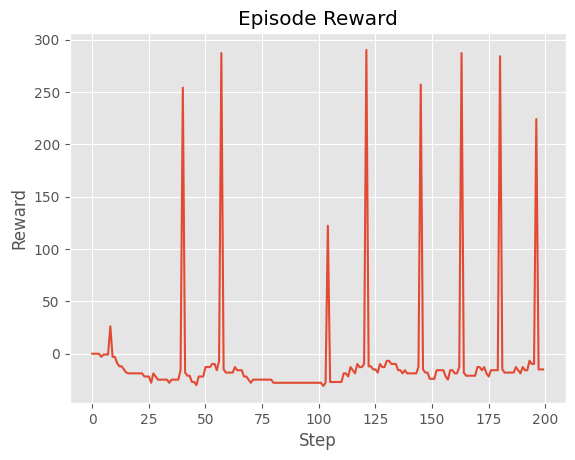

In [99]:
from matplotlib import pyplot as plt

#plot smoothed rewards for 1 episode
plt.plot(rewards_episodes[0])
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Episode Reward")
plt.show()

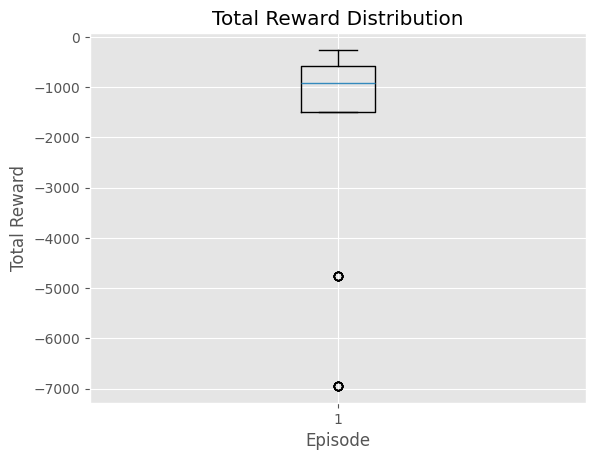

In [100]:
#plot box plot of episodic rewards
rewards_episodes_sum = rewards_episodes.sum(axis=1)
plt.boxplot(rewards_episodes_sum)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward Distribution")
plt.show()